## TSCeption

### Downloading Dataset

In [1]:
!wget https://physionet.org/static/published-projects/eegmat/eeg-during-mental-arithmetic-tasks-1.0.0.zip

--2024-07-04 09:27:53--  https://physionet.org/static/published-projects/eegmat/eeg-during-mental-arithmetic-tasks-1.0.0.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 183634285 (175M) [application/zip]
Saving to: 'eeg-during-mental-arithmetic-tasks-1.0.0.zip'

eeg-during-mental-a 100%[===================>] 175.13M   432KB/s    in 7m 4s   

2024-07-04 09:34:57 (423 KB/s) - 'eeg-during-mental-arithmetic-tasks-1.0.0.zip' saved [183634285/183634285]



In [2]:
!unzip eeg-during-mental-arithmetic-tasks-1.0.0.zip

Archive:  eeg-during-mental-arithmetic-tasks-1.0.0.zip
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject29_2.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject24_1.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject12_2.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject02_2.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject15_1.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject16_1.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject08_1.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/SHA256SUMS.txt  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject34_2.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject32_1.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject18_1.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject27_1.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject17_1.edf  
 extractin

### Importing Libraries

In [3]:
!pip install pyedflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 47.9 MB/s eta 0:00:0000:01


In [4]:
import pandas as pd
import numpy as np
import os
import pyedflib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy import interpolate
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc


### Checking Device

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Data Loading and Processing

In [6]:
directory_path = "eeg-during-mental-arithmetic-tasks-1.0.0"

def process_edf(file_path):
    f = pyedflib.EdfReader(file_path)

    num_signals = f.signals_in_file

    signal_labels = f.getSignalLabels()

    signals = []
    for i in range(num_signals):
        signals.append(f.readSignal(i))

    f.close()
    
    return np.array(signals), signal_labels


signals = []
signal_labels = []
file_name = []
for filename in os.listdir(directory_path):
    if filename.endswith(".edf"):
        file_name.append(filename)
        file_path = os.path.join(directory_path, filename)
        a ,b = process_edf(file_path)
        signals.append(a)
        signal_labels.append(b)

In [7]:
df = pd.DataFrame({
    'Signal': signals,
    'Name': file_name,
})
df.sort_values(by='Name', ascending=True, inplace=True)
df = df.reset_index().drop(columns=['index'])
df['State'] = df['Name'].str[10:11].astype(int)
df['Person'] = df['Name'].str[7:9].astype(int)
df = df.drop(columns = ['Name'])
df = pd.get_dummies(df , columns = ['State'] , drop_first = True)

In [8]:
df.head()

,Signal,Person,State_2
0,"[[-3.647937628137637, -4.2364816766613265, -4....",0,False
1,"[[4.476049125658048, 1.2080211680781288, -2.54...",0,True
2,"[[-6.347912214236662, -5.884709218585484, -5.1...",1,False
3,"[[13.990337165484092, 12.876662806134126, 11.8...",1,True
4,"[[-1.4898168015564115, -3.518470470435636, -5....",2,False


In [9]:
avg = 0
for index, row in df.iterrows():
    avg = avg + row['Signal'].shape[1]
avg = avg / 72
avg

60250.0

In [10]:
print(f"Shape of each each tensor in state 1 {df['Signal'][0].shape}")
print(f"Shape of each each tensor in state 2 {df['Signal'][1].shape}")

Shape of each each tensor in state 1 (21, 91000)
Shape of each each tensor in state 2 (21, 31000)


In [11]:
def pad_or_truncate(signal):
    target_length = 60250
    if signal.shape[1] > target_length:
        return signal[:, :target_length]
    else:
        pad_width = target_length - signal.shape[1]
        return np.pad(signal, ((0, 0), (0, pad_width)), mode='constant')

df['Signal']=df['Signal'].apply(pad_or_truncate)
print(f"Shape of each each tensor in state 1 {df['Signal'][0].shape}")
print(f"Shape of each each tensor in state 2 {df['Signal'][1].shape}")

Shape of each each tensor in state 1 (21, 60250)
Shape of each each tensor in state 2 (21, 60250)


In [12]:
x_train, x_test, y_train, y_test = train_test_split(
    df['Signal'], df['State_2'], test_size=0.20, random_state=42,stratify = df['State_2'])
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [13]:
class CustomDataset(Dataset):
    def __init__(self, X_train, y_train, transform=None):
        self.X_train = X_train
        self.y_train = y_train
        self.transform = transform

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        x = self.X_train[idx]
        y = self.y_train[idx]
        
        if self.transform:
            x = self.transform(x)

        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
        y = torch.tensor(y, dtype=torch.float32)

        return x.to(device), y.to(device)

### Defining Model Class

In [49]:
class Tsception(nn.Module):
    def __init__(self):
        super(Tsception, self).__init__()

        self.temporal_conv1 = nn.Conv2d(1, 16, (1, 8), padding=(0, 4),stride=(1,5))
        self.temporal_conv2 = nn.Conv2d(1, 16, (1, 16), padding=(0, 8),stride=(1,5))
        self.spatial_conv1 = nn.Conv2d(32, 64, (21, 1),stride = (1,5))

        self.fc1 = nn.Linear(154304 , 1000)
        self.fc2 = nn.Linear(1000, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = torch.relu(self.temporal_conv1(x))
        print(x1.shape)
        x2 = torch.relu(self.temporal_conv2(x))
        print(x2.shape)

        x = torch.cat((x1, x2), dim=1)
        print(x.shape)

        x = torch.relu(self.spatial_conv1(x))
        print(x.shape)

        x = x.view(x.size(0), -1) 
        print(x.shape)

        x = torch.relu(self.fc1(x))
        print(x.shape)

        x = self.fc2(x)
        print(x.shape)

        x = self.sigmoid(x)
        
        return x

In [50]:
x = torch.randn(1,1,21,60250)
model = Tsception()
model(x)

torch.Size([1, 16, 21, 12051])
torch.Size([1, 16, 21, 12051])
torch.Size([1, 32, 21, 12051])
torch.Size([1, 64, 1, 2411])
torch.Size([1, 154304])
torch.Size([1, 1000])
torch.Size([1, 1])


tensor([[0.4900]], grad_fn=<SigmoidBackward0>)

In [40]:
dataset = CustomDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [41]:
net = Tsception().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

### Model Training

In [42]:
num_epochs = 10
loss_e = []

for epoch in range(num_epochs):
    running_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for x, y in progress_bar:
        optimizer.zero_grad()
        outputs = net(x)
        loss = criterion(outputs, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1))
        
        del x, y, outputs, loss
        gc.collect()
        torch.cuda.empty_cache()
    
    avg_epoch_loss = running_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')
    loss_e.append(avg_epoch_loss)

Epoch 1/10: 100%|██████████| 4/4 [00:01<00:00,  2.00it/s, loss=0.2]  


Epoch [1/10], Loss: 0.1997


Epoch 2/10: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, loss=5.84e-8]


Epoch [2/10], Loss: 0.0000


Epoch 3/10: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s, loss=7.42e-15]


Epoch [3/10], Loss: 0.0000


Epoch 4/10: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, loss=3.22e-19]


Epoch [4/10], Loss: 0.0000


Epoch 5/10: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s, loss=3.88e-22]


Epoch [5/10], Loss: 0.0000


Epoch 6/10: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, loss=3.88e-24]


Epoch [6/10], Loss: 0.0000


Epoch 7/10: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s, loss=1.62e-25]


Epoch [7/10], Loss: 0.0000


Epoch 8/10: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s, loss=1.8e-26] 


Epoch [8/10], Loss: 0.0000


Epoch 9/10: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s, loss=3.91e-27]


Epoch [9/10], Loss: 0.0000


Epoch 10/10: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s, loss=1.37e-27]

Epoch [10/10], Loss: 0.0000


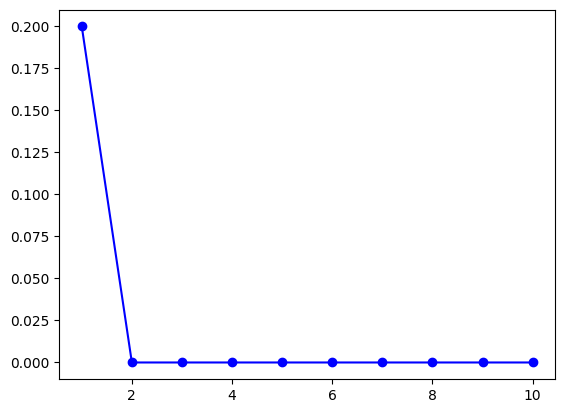

In [44]:
epochs =np.array(range(0, 10))+1
plt.plot(epochs, loss_e, marker='o', linestyle='-', color='b')
plt.show()

### Evaluation

In [45]:
def check_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():  
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            predicted = (outputs > 0.5).float() 
            total += y.size(0)
            correct += (predicted == y.unsqueeze(1)).sum().item()
    
    accuracy = correct / total
    model.train()  
    return accuracy

In [46]:
test_dataset = CustomDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
print("Accuracy on test data is : ",check_accuracy(net,test_loader,device))

Accuracy on test data is :  1.0


In [47]:
print("Accuracy on train data is : ",check_accuracy(net,dataloader,device))

Accuracy on train data is :  1.0


In [48]:
x = df['Signal']
y = df['State_2']
t_dataset = CustomDataset(x, y)
t_loader = DataLoader(t_dataset, batch_size=4, shuffle=False)
print("Accuracy on entire data is : ",check_accuracy(net,t_loader,device))

Accuracy on entire data is :  1.0
